In [1]:
# Notebook to simulate diffusion equation for the MHD systems

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from tqdm.auto import tqdm

C:\Users\cdipt\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\cdipt\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\cdipt\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\cdipt\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [145]:
d_t = 0.01

r_min = 1e-3
r_max = 10


t_min = 0
t_max = 2

d_r = 0.01                        # For uniform grid in r
r = np.arange(r_min, r_max, d_r)  # For uniform grid in r
dr = np.diff(r, prepend=0) 

h = 0.1*np.ones_like(r)           # Assuming a constant h (Slab Geometry, No flaring)

t = np.arange(t_min, t_max, d_t)  # For uniformly spaced time intervals
dt = np.diff(t)                   # For uniformly spaced time intervals

In [146]:
omega = np.zeros(len(r))    # Omega effect
alpha = np.zeros(len(r))    # Alpha effect

V_r = np.zeros(len(r))      # radial velocity
V_phi = np.zeros(len(r))    # angular velocity
V_z = np.zeros(len(r))      # vertical velocity

eta_m = 0.02          # microscopic diffusivity
eta_t = 0.2             # kinetic diffusivity
eta = eta_m + eta_t     # total diffusivity

In [174]:
B_r = np.sin( 0.4*np.sin(np.pi *7* (r) / (r_max-dr[-1])) + np.pi * (r) / (r_max-dr[-1])) # np.ones(len(r)) * np.sin(np.pi * r)
B_phi = - np.sin( 0.4*np.sin(np.pi *6* (r) / (r_max-dr[-1])) + np.pi * (r) / (r_max-dr[-1]))  # np.ones(len(r)) * np.sin(np.pi * r)

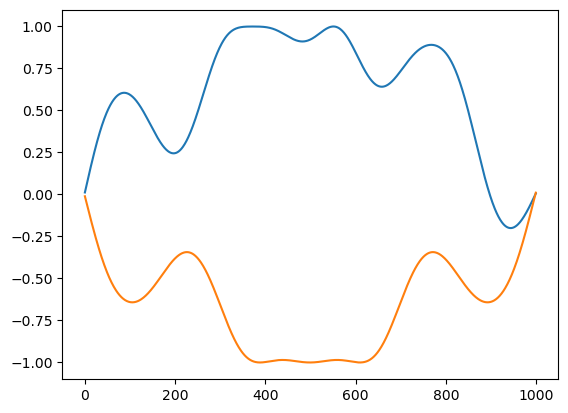

In [175]:
plt.plot(B_r)
plt.plot(B_phi)

In [167]:
# Solving Equations iteratively

# The differential equation in Br
def Eqn_Br(Br, Bphi, dr=dr, eta = eta):
    """
    Br: np.array(n,): Stores the vale of Br at time step t for all r
    B_phi:  np.array(n,): Stores the vale of B_phi at time step t for all r
    dr: np.array(n,):Grid Spacing
    eta: (float) diffusivity
    """
    diag = ((-V_r/r + V_z/(4*h) - eta/(r**2) -(2*eta)/(dr**2) - (eta*np.pi**2)/(4*h**2))[None,:]*np.eye(B_r.shape[0]))

    upper_diag = np.zeros((B_r.shape[0],B_r.shape[0])) 
    upper_diag[:-1,1:]  = ((-V_r/(2*dr) + eta/(dr**2) + eta/(2*r*dr))[None,:]*np.eye(B_r.shape[0]))[1:,1:] 

    lower_diag = np.zeros((B_r.shape[0],B_r.shape[0])) 
    lower_diag[1:,:-1] = ((V_r/(2*dr)+ eta/(dr**2) -eta/(2*r*dr))[None,:]*np.eye(B_r.shape[0]))[:-1,:-1]

    diag2 = ((2*alpha)/(np.pi*h)[None,:]*np.eye(B_phi.shape[0]))
    mat1 = diag + upper_diag + lower_diag
    mat2 = diag2.copy()
    k = (mat1@B_r[:,None])[:,0] + (mat2@B_phi[:,None])[:,0]
    k[[0,-1]] = 0
    return k*d_t

# Full Eqn in Bphi
def Eqn_Bphi(Br,Bphi,dr=dr,eta=eta):
    diag =  (-1*(2*eta)/(dr**2) - eta/(r**2) - (eta*np.pi**2)/(4*h**2))[None,:]*np.eye(B_phi.shape[0])
    
    upper_diag = np.zeros((B_phi.shape[0],B_phi.shape[0])) 
    upper_diag[:-1,1:]  = ((eta/(dr**2) + eta/(2*r*dr))[None,:]*np.eye(B_phi.shape[0]))[1:,1:] 

    lower_diag = np.zeros((B_r.shape[0],B_r.shape[0])) 
    lower_diag[1:,:-1] = ((eta/(dr**2) - eta/(2*r*dr))[None,:]*np.eye(B_phi.shape[0]))[:-1,:-1]
                                                                                       
    diag2 = ((2*alpha)/(np.pi*h))[None,:]*np.eye(B_r.shape[0])
    
    mat1 = diag + upper_diag + lower_diag
    mat2 = diag2.copy()
    k = (mat1@B_phi[:,None])[:,0] + (mat2@B_r[:,None])[:,0]
    k[[0,-1]] = 0
    return k*d_t
                                                                                       


# Runge Kutta Step
def runge_kutta_step(Br, Bphi, dt, eta=eta):
    k1_r = dt *  Eqn_Br(Br, Bphi)
    k1_phi = dt *  Eqn_Bphi(Br, Bphi)

    k2_r = dt *  Eqn_Br(Br + 0.5 * k1_r, Bphi + 0.5 * k1_phi)
    k2_phi = dt *  Eqn_Bphi(Br + 0.5 * k1_r, Bphi + 0.5 * k1_phi)

    k3_r = dt *  Eqn_Br(Br + 0.5 * k2_r, Bphi + 0.5 * k2_phi)
    k3_phi = dt *  Eqn_Bphi(Br + 0.5 * k2_r, Bphi + 0.5 * k2_phi)

    k4_r = dt *  Eqn_Br(Br + k3_r, Bphi + k3_phi)
    k4_phi = dt *  Eqn_Bphi(Br + k3_r, Bphi + k3_phi)

    return (Br + (k1_r + 2 * k2_r + 2 * k3_r + k4_r) / 6, Bphi + (k1_phi + 2 * k2_phi + 2 * k3_phi + k4_phi) / 6)


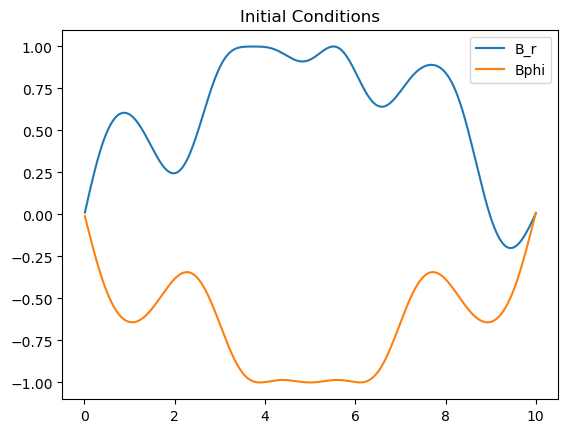

In [176]:
plt.plot(r, B_r, label="B_r")
plt.plot(r, B_phi, label="Bphi")
plt.title("Initial Conditions")
# plt.xlim(0, 12)
plt.legend()
plt.show()

In [177]:
d_t = 0.01

r_min = 0.01
r_max = 10


t_min = 0
t_max = 2

d_r = 0.01                        # For uniform grid in r
r = np.arange(r_min, r_max+d_r, d_r)  # For uniform grid in r
dr = np.diff(r, prepend=0) 

h = 0.1*np.ones_like(r)           # Assuming a constant h (Slab Geometry, No flaring)

t = np.arange(t_min, t_max, d_t)  # For uniformly spaced time intervals
dt = np.diff(t)                   # For uniformly spaced time intervals

# Time-stepping scheme using Runge-Kutta
B_r_evolution = []
B_phi_evolution = []
time = []
B_r_decay = []
B_phi_decay = []
B_r_t = B_r
Bphi_t = B_phi
r_val = 5 
r_index = np.where(r == r_val)[0][0]
for i in tqdm(range(len(dt))):
    time_step = dt[i]
    if i%50 == 0:
        B_r_evolution.append(B_r_t)
        B_phi_evolution.append(Bphi_t)
    time.append(t_min + i*d_t)
    B_r_decay.append(B_r_t[r_index])
    B_phi_decay.append(Bphi_t[r_index])
    B_r_t,Bphi_t = runge_kutta_step(B_r_t, Bphi_t, dt=time_step)

  0%|          | 0/199 [00:00<?, ?it/s]

In [123]:
r.shape

(999,)

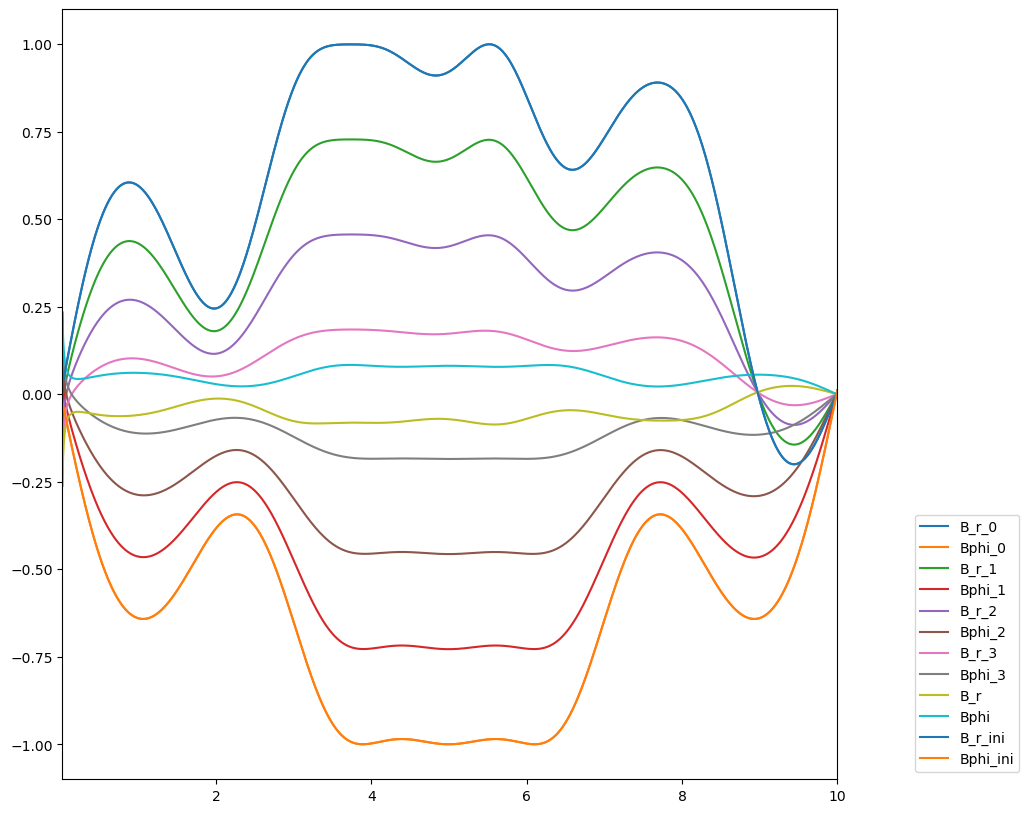

In [178]:
plt.figure(figsize=(10, 10))
for i in range(len(B_r_evolution)):
    plt.plot(r, B_r_evolution[i], label=f"B_r_{i}")
    plt.plot(r, B_phi_evolution[i], label=f"Bphi_{i}")

plt.plot(r, B_r_t, label="B_r")
plt.plot(r, Bphi_t, label="Bphi")
plt.plot(r, B_r, label="B_r_ini")
plt.plot(r, B_phi, label="Bphi_ini")
plt.legend(loc=(1.1,0.01))
plt.xlim(0.02,10)
plt.show()

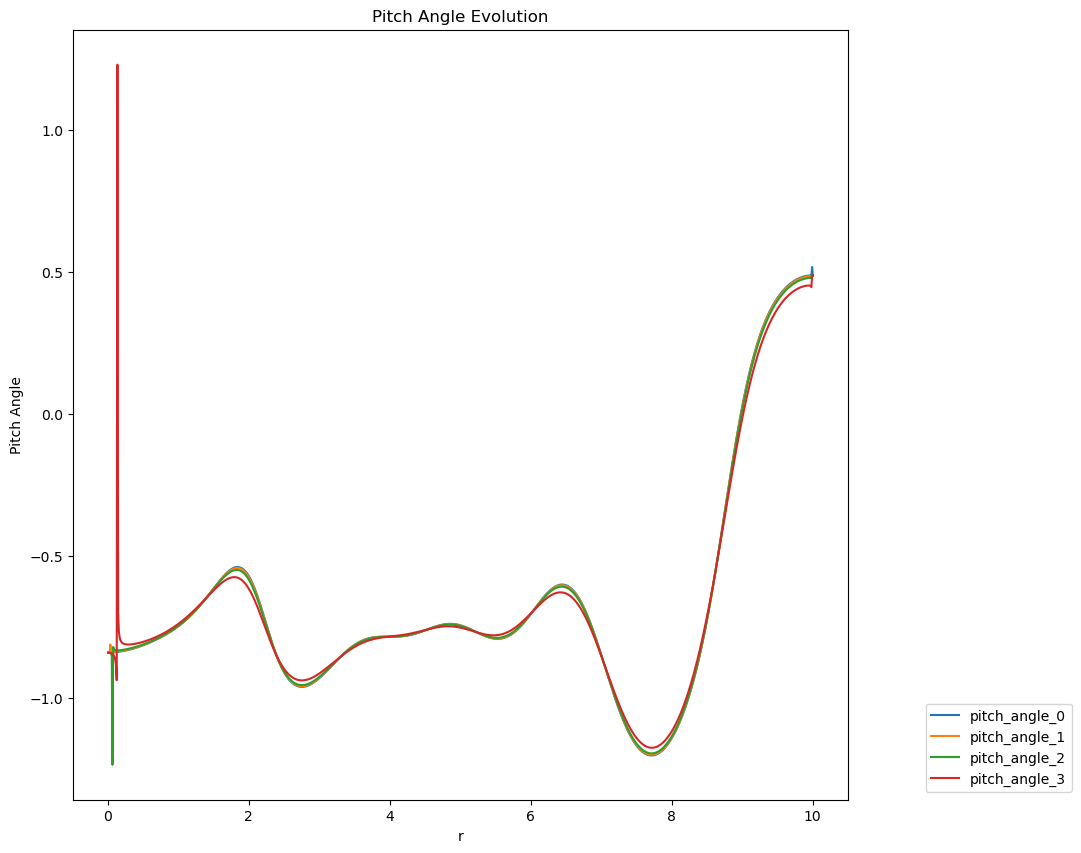

In [179]:
def pitch_angle(Br, Bphi):
    return np.arctan(Br/Bphi)

plt.figure(figsize=(10, 10))
plt.title("Pitch Angle Evolution")
for i in range(len(B_r_evolution)):
    plt.xlabel("r")
    plt.ylabel("Pitch Angle")
    plt.plot(r, pitch_angle(B_r_evolution[i], B_phi_evolution[i]), label=f"pitch_angle_{i}")
plt.legend(loc=(1.1,0.01))